In [1]:
pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.

In [3]:
# Básicas
import os
import cv2
import numpy as np
from PIL import Image

# Treinamento (YOLOv8 recomendado)
from ultralytics import YOLO
import torch

# Avaliação
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Visualização
import matplotlib.patches as patches

In [4]:
model = YOLO("yolov8n.pt")  # Carrega um modelo pré-treinado
#results = model.train(data="custom.yaml", epochs=50)  # Treina com seus dados

100%|██████████| 6.25M/6.25M [00:00<00:00, 99.3MB/s]


In [5]:
!git clone https://github.com/pedrozamboni/individual_urban_tree_crown_detection.git

Cloning into 'individual_urban_tree_crown_detection'...
remote: Enumerating objects: 696, done.
remote: Total 696 (delta 0), reused 0 (delta 0), pack-reused 696 (from 1)
Receiving objects: 100% (696/696), 184.86 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (677/677), done.


In [6]:
!pip install ultralytics opencv-python Pillow  # Bibliotecas para YOLOv8 e processamento

In [8]:
import os
import cv2
import shutil
from tqdm import tqdm

# Caminhos
base_path = "/content/individual_urban_tree_crown_detection"
output_path = "/content/datasets/tree_detection"
img_width, img_height = 640, 640  # Substitua pelas dimensões reais das suas imagens

# Criar estrutura de pastas
os.makedirs(f"{output_path}/train/labels", exist_ok=True)
os.makedirs(f"{output_path}/train/images", exist_ok=True)

# Processar cada arquivo de anotação
for txt_file in tqdm(os.listdir(f"{base_path}/bbox_txt")):
    if txt_file.endswith('.txt'):
        # Obter nome da imagem correspondente
        img_name = txt_file.replace('.txt', '.png')
        img_path = f"{base_path}/rgb/{img_name}"

        # Carregar imagem para verificar dimensões (opcional)
        img = cv2.imread(img_path)
        if img is not None:
            img_height, img_width = img.shape[:2]

        # Processar anotações
        with open(f"{base_path}/bbox_txt/{txt_file}", 'r') as f_in, \
             open(f"{output_path}/train/labels/{txt_file}", 'w') as f_out:

            for line in f_in:
                parts = line.strip().split()
                if len(parts) >= 4:
                    class_id = 0  # Definimos como 0 (árvore)
                    xmin, ymin, xmax, ymax = map(float, parts[:4])

                    # Converter para formato YOLO (coordenadas normalizadas)
                    x_center = (xmin + xmax) / 2 / img_width
                    y_center = (ymin + ymax) / 2 / img_height
                    width = (xmax - xmin) / img_width
                    height = (ymax - ymin) / img_height

                    # Garantir que as coordenadas estão entre 0 e 1
                    x_center = max(0, min(1, x_center))
                    y_center = max(0, min(1, y_center))
                    width = max(0, min(1, width))
                    height = max(0, min(1, height))

                    f_out.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        # Copiar imagem para a pasta de treino
        if os.path.exists(img_path):
            shutil.copy(img_path, f"{output_path}/train/images/{img_name}")

100%|██████████| 220/220 [00:03<00:00, 69.98it/s]


In [9]:
import random

# Listar todas as imagens
all_images = [f for f in os.listdir(f"{output_path}/train/images") if f.endswith('.png')]
random.shuffle(all_images)

# Criar pasta de validação
os.makedirs(f"{output_path}/val/images", exist_ok=True)
os.makedirs(f"{output_path}/val/labels", exist_ok=True)

# Mover 20% para validação
for img in all_images[:int(0.2*len(all_images))]:
    base_name = img.replace('.png', '')
    # Mover imagem
    shutil.move(
        f"{output_path}/train/images/{img}",
        f"{output_path}/val/images/{img}"
    )
    # Mover label
    shutil.move(
        f"{output_path}/train/labels/{base_name}.txt",
        f"{output_path}/val/labels/{base_name}.txt"
    )

In [10]:
# Verificar quantas imagens foram processadas
print(f"Treino: {len(os.listdir(f'{output_path}/train/images'))} imagens")
print(f"Validação: {len(os.listdir(f'{output_path}/val/images'))} imagens")

# Verificar uma anotação de exemplo
!head {output_path}/train/labels/0.txt

Treino: 176 imagens
Validação: 44 imagens
0 0.041016 0.398438 0.082031 0.199219
0 0.207031 0.301758 0.109375 0.115234
0 0.227539 0.415039 0.091797 0.080078
0 0.252930 0.475586 0.083984 0.091797
0 0.385742 0.437500 0.044922 0.054688
0 0.627930 0.391602 0.150391 0.162109
0 0.103516 0.966797 0.207031 0.066406
0 0.269531 0.776367 0.250000 0.208984


In [12]:
from ultralytics import YOLO

# Carregar modelo
model = YOLO('yolov8n.pt')

# Treinar com callbacks de verificação
model.train(
    data=f'tree_config.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    val=True,  # Garantir que a validação seja executada
    save=True,
    exist_ok=True
)

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=tree_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profil

100%|██████████| 755k/755k [00:00<00:00, 19.9MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 98.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2245.1±1534.6 MB/s, size: 438.6 KB)


train: Scanning /content/datasets/tree_detection/train/labels... 176 images, 1 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<00:00, 1037.78it/s]

train: New cache created: /content/datasets/tree_detection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2172.6±1387.1 MB/s, size: 429.7 KB)


val: Scanning /content/datasets/tree_detection/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 771.42it/s]

val: New cache created: /content/datasets/tree_detection/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.43G       2.06      3.352      1.789        387        640: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


                   all         44        631     0.0304      0.635      0.105     0.0446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.62G      1.785      1.911      1.425        274        640: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         44        631     0.0547      0.765      0.492      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.64G      1.756       1.56      1.357        390        640: 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         44        631      0.777       0.52      0.613      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.82G      1.724      1.473      1.373        325        640: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         44        631      0.767      0.528      0.614      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.84G      1.712      1.494      1.376        299        640: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         44        631      0.712      0.513      0.588      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.86G      1.685       1.47      1.364        248        640: 100%|██████████| 11/11 [00:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


                   all         44        631      0.432      0.481      0.403        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.87G      1.657      1.383      1.363        390        640: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         44        631      0.493      0.423      0.397      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.89G      1.688      1.389      1.371        346        640: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         44        631      0.638      0.479      0.521      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.9G      1.682      1.333      1.343        351        640: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         44        631       0.69      0.559      0.614      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.1G      1.582      1.272      1.307        438        640: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         44        631      0.673      0.593       0.63      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.12G      1.623      1.286      1.334        431        640: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         44        631      0.665      0.596      0.652      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.14G      1.613      1.276      1.316        325        640: 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         44        631      0.687      0.612       0.67      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.34G      1.589      1.242      1.322        321        640: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         44        631      0.654      0.628      0.656      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.36G      1.593      1.242      1.311        372        640: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         44        631      0.706       0.61      0.674      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.37G      1.536      1.202      1.292        320        640: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         44        631      0.693      0.596      0.657      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.39G      1.595      1.226      1.308        374        640: 100%|██████████| 11/11 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         44        631       0.68      0.604      0.656      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.41G      1.558      1.177      1.292        354        640: 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         44        631      0.734      0.609      0.686       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.43G      1.548      1.174      1.292        338        640: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         44        631      0.723      0.626      0.692      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.44G      1.552      1.135      1.279        420        640: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         44        631      0.707      0.628      0.693      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.46G      1.564      1.169      1.301        284        640: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         44        631      0.694      0.586      0.649      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.48G      1.555      1.145      1.288        315        640: 100%|██████████| 11/11 [00:02<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         44        631      0.737      0.626      0.697      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.49G      1.522      1.099       1.28        385        640: 100%|██████████| 11/11 [00:02<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         44        631      0.728       0.65      0.719      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.51G      1.533      1.113       1.29        339        640: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         44        631      0.728      0.627      0.702      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.53G       1.51      1.123      1.274        374        640: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         44        631      0.705      0.613      0.681      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.54G       1.46       1.06      1.231        321        640: 100%|██████████| 11/11 [00:02<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         44        631      0.687      0.601      0.651      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.56G      1.482      1.056       1.26        268        640: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         44        631      0.739       0.64      0.703      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.58G       1.46      1.022      1.232        376        640: 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         44        631      0.745      0.639      0.697      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       3.6G       1.46      1.028       1.25        288        640: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         44        631      0.727       0.64      0.692      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.61G      1.448      1.015      1.243        301        640: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         44        631      0.758      0.593      0.679      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.63G      1.432      1.017      1.225        360        640: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         44        631       0.75      0.597      0.673       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.65G      1.426      1.001       1.23        361        640: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         44        631      0.779      0.641      0.726      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.66G      1.435     0.9738      1.216        325        640: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         44        631      0.786      0.657      0.738      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.68G      1.447     0.9873      1.231        350        640: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         44        631      0.782      0.649       0.73      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       3.7G      1.446     0.9875      1.228        321        640: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         44        631      0.764      0.665      0.744      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.71G      1.422     0.9761      1.215        408        640: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         44        631      0.752      0.675      0.749      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.73G      1.397     0.9532      1.217        321        640: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         44        631      0.767      0.675      0.747      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.75G      1.377     0.9303      1.196        338        640: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         44        631      0.739        0.7      0.739      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.77G      1.378     0.9197      1.193        431        640: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         44        631      0.786      0.659      0.733      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.78G      1.337     0.8982      1.171        266        640: 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         44        631      0.755      0.678      0.736      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.8G       1.34     0.8845       1.17        390        640: 100%|██████████| 11/11 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         44        631      0.756       0.67      0.745      0.402


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.82G       1.35       0.99      1.174        248        640: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


                   all         44        631       0.78      0.634      0.716      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.83G      1.349      0.928      1.194        179        640: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         44        631      0.768      0.635      0.714      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.85G      1.339     0.9069      1.197        189        640: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         44        631      0.755      0.693      0.745      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.87G      1.329     0.8935      1.189        216        640: 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         44        631      0.752      0.705      0.754      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.88G      1.301     0.8664      1.154        224        640: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         44        631      0.772      0.691      0.733      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       3.9G      1.304     0.8706       1.17        240        640: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         44        631      0.765      0.694      0.732      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.92G      1.302     0.8623      1.163        213        640: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         44        631       0.78      0.687      0.742      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.94G      1.288     0.8487      1.156        229        640: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         44        631      0.772      0.686      0.736      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.95G      1.264     0.8275      1.157        210        640: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


                   all         44        631       0.77      0.688      0.739      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.97G      1.255     0.8211      1.159        162        640: 100%|██████████| 11/11 [00:02<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         44        631      0.766        0.7      0.748      0.404



50 epochs completed in 0.061 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


                   all         44        631      0.752      0.677      0.749      0.411
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78d7e6a5d990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

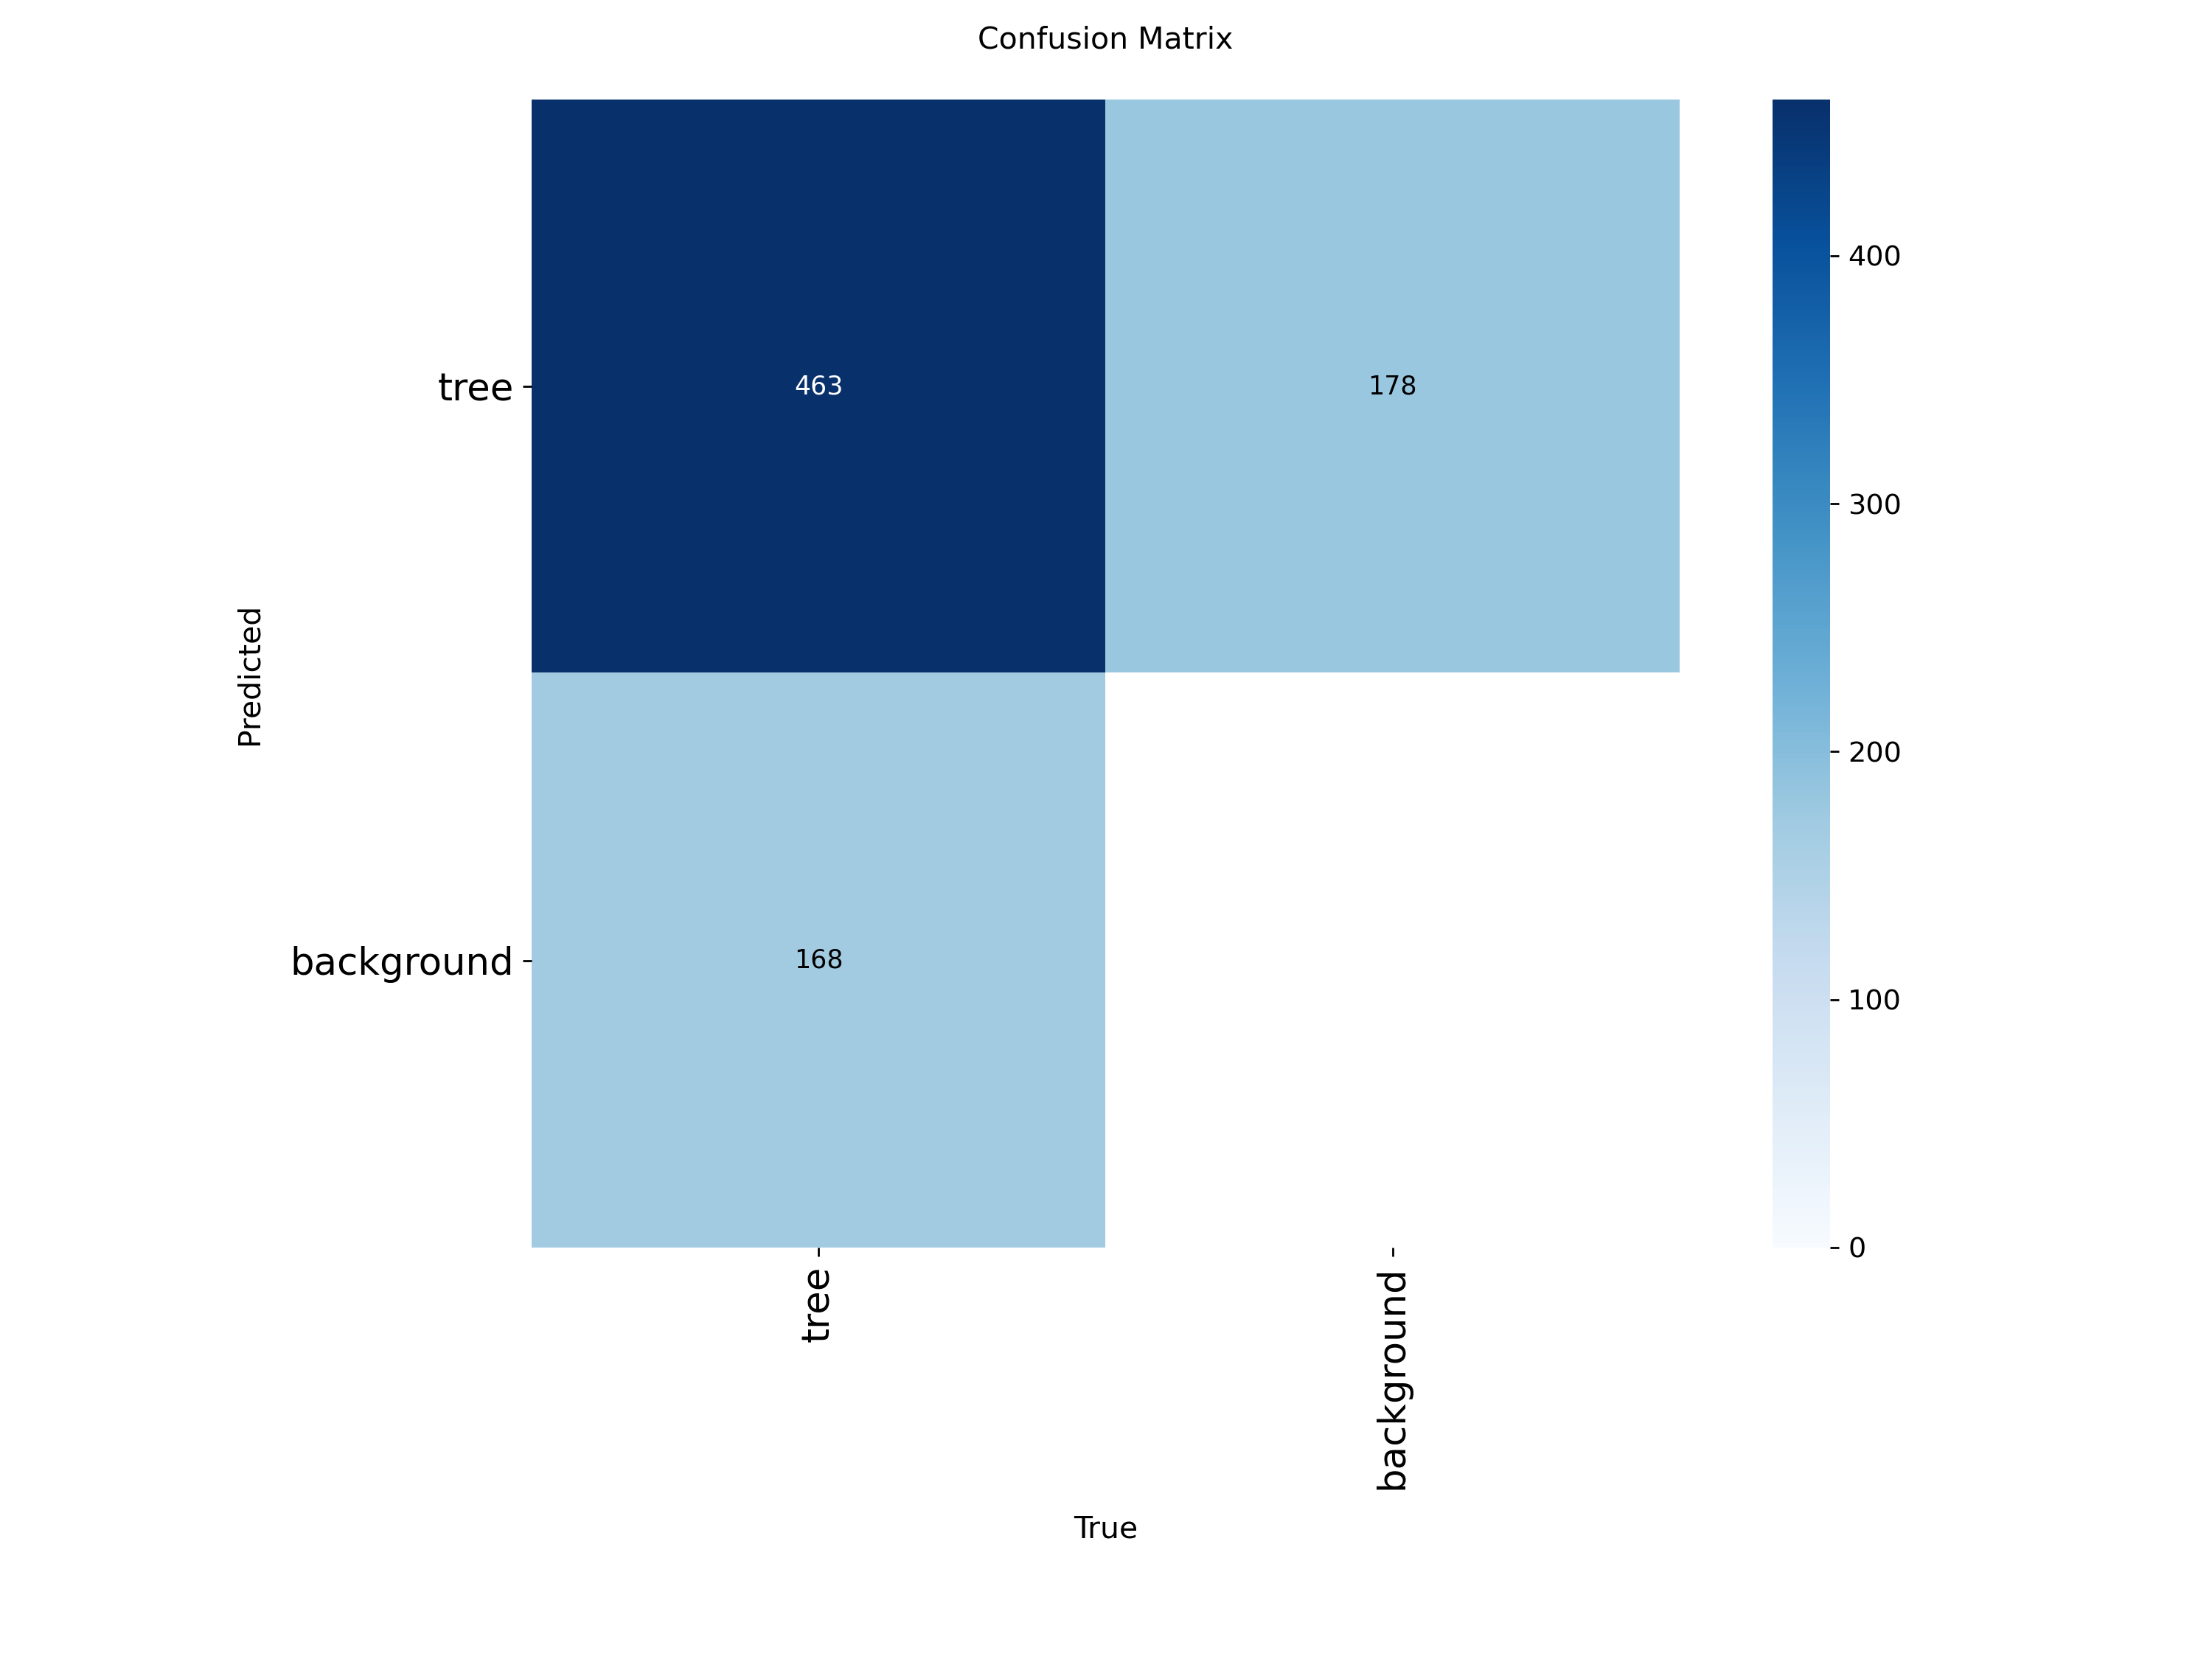

In [13]:
from IPython.display import Image

# Mostrar resultados de treinamento
Image(filename='runs/detect/train/results.png')  # Gráficos de loss e métricas
Image(filename='runs/detect/train/confusion_matrix.png')  # Matriz de confusão

In [19]:
from ultralytics import YOLO

# Carregar o modelo treinado
model = YOLO('runs/detect/train/weights/best.pt')  # Melhores pesos

#exclui pasta predict para gerar uma nova
!rm -rf runs/detect/predict

# Previsão em uma imagem
results = model.predict(
    source='mapa2.jpg',
    conf=0.5,  # Limite de confiança
    save=True  # Salva resultados em runs/detect/predict/
)


image 1/1 /content/mapa2.jpg: 384x640 9 trees, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


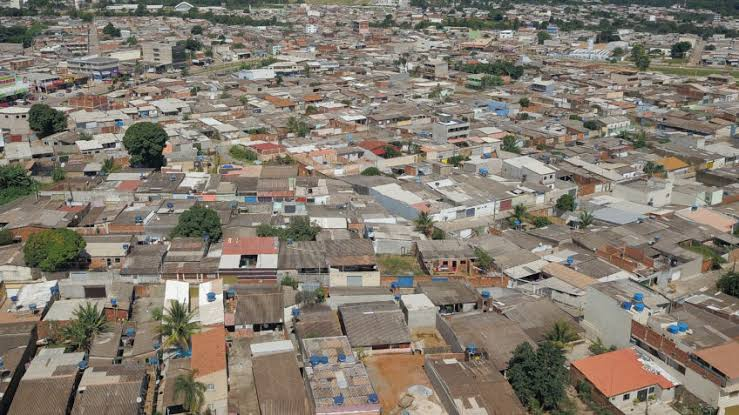

In [21]:
#Imagem de entrada
Image(filename='mapa2.jpg')

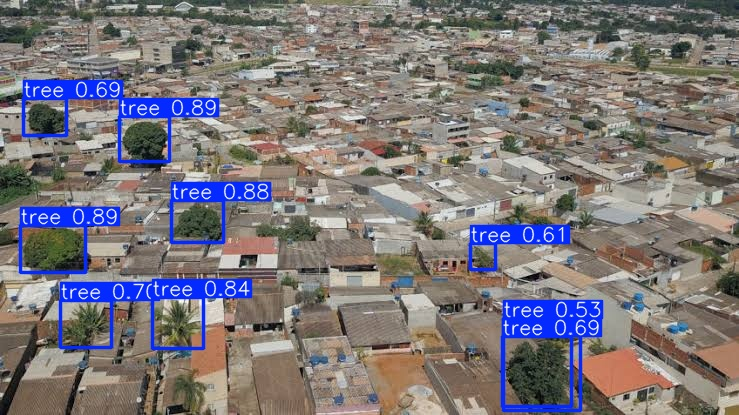

In [20]:
# Visualizar resultados
Image(filename='runs/detect/predict/mapa2.jpg')